In [2]:
import torch.nn as nn
import torch.optim as optim
from resnet import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
import os
import torchvision.models as models
from skimage import io, transform


import torch.backends.cudnn as cudnn
import torch
import re
import PIL
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tr
from matplotlib import pyplot as plt

''' random seed fixed'''
import random

path = "/home/sldev1/Project/hyeongeun_test/data/FER"
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [3]:
#Simple Learning Rate Scheduler
def lr_scheduler(optimizer, epoch):
    lr = learning_rate
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Xavier
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
from torch.utils.data import Dataset
import glob


def img_load(img_path):

    jpg = glob.glob(img_path+'*.jpg')
    sort_jpg = sorted(jpg, key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("img_load def is play")
    return sort_jpg


def label_load(label_path):

    label = glob.glob(label_path+'*exp.npy')
    sort_label = sorted(label,key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("label_load def is play")
    return sort_label
    

class MyFERDataset(Dataset):
    
    def __init__(self, img_path_base, label_path_base, train=None, transform=None):
        super(MyFERDataset, self).__init__()
        
        if train == True:
            self.img_path = img_path_base+'/train_set/images/'
            self.label_path = label_path_base+'/train_set/annotations/'
        else:
            self.img_path = img_path_base+'/val_set/images/'
            self.label_path = label_path_base+'/val_set/annotations/'

        self.img = img_load(self.img_path)
        self.label = label_load(self.label_path)
        self.transform = transform
        
    
    def __getitem__(self, idx):
        img_read = io.imread(self.img[idx]) 
        label_read = np.load(self.label[idx])
        label_read = label_read.astype(np.int64)
        label_tr = torch.from_numpy(label_read)
        
        
        if self.transform:
            img_tr = self.transform(img_read)
        
        
        return img_tr, label_tr
    

    def __len__(self):
        return len(self.label)
    
    if __name__ == "__main__":
        print('hi, i\'m main')

hi, i'm main


# 11월 3일 목요일(학습 완료했지만, happiness로만 예측함.)
- 관련해서 라벨링이 happiness로만 들어갔는지 검토중
- for문 안에서 잘못됬는지 잘모르겠음.

# 사전에 에폭이 2번밖에 안돌아서 acc가 낮을 것이고 happiness만 들어갔을 것이라고 예측하심(강민규사원님)

In [5]:
transform_train = tr.Compose([tr.ToTensor(),
                              tr.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
transform_test = tr.Compose([tr.ToTensor()])


train_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=True,
                              transform=transform_train)
test_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=False,
                              transform=transform_test)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [8]:
labels.size()
#print(images)

torch.Size([4])

In [9]:
print(labels)

tensor([0, 1, 0, 1])


In [10]:
device = 'cuda'
model = ResNet50()
# ResNet18, ResNet34, ResNet50, ResNet101, ResNet152 중에 택일하여 사용

In [11]:
model.apply(init_weights)
model = model.to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [12]:
learning_rate = 0.001
num_epoch = 200
model_name = 'FER_ResNet1104.pt'

loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0

In [13]:
# Train
for epoch in range(num_epoch):
    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    model.train()
    lr_scheduler(optimizer, epoch)
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    # Train Phase
    for step, batch in enumerate(train_loader):
        #  input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        
        logits = model(batch[0]) #ResNet50(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        #_, predict = logits.max(1)
        _, predict = torch.max(logits, dim=1)
        
        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()
        
        if step % 1000 == 0 and step != 0:
            print(f"\n====== { step } Step of { len(train_loader) } ======")
            print(f"Train Acc : { correct / total_cnt }")
            print(f"Train Loss : { loss.item() / batch[1].size(0) }")
            
    correct = 0
    total_cnt = 0
    
# Test Phase
    with torch.no_grad():
        model.eval()
        for step, batch in enumerate(test_loader):
            # input and target
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
            total_cnt += batch[1].size(0)
            logits = model(batch[0])
            valid_loss += loss_fn(logits, batch[1])
            _, predict = logits.max(1)
            correct += predict.eq(batch[1]).sum().item()
        valid_acc = correct / total_cnt
        print(f"\nValid Acc : { valid_acc }")    
        print(f"Valid Loss : { valid_loss / total_cnt }")

        if(valid_acc > best_acc):
            best_acc = valid_acc
            # torch.save(model, model_name)
            # print("Model Saved!")
            torch.save(model.state_dict(), model_name)
            print('Detected network improvement, saving current model')

====== 1 epoch of 200 ======

====== 1000 Step of 71913 ======
Train Acc : 0.41983016983016985
Train Loss : 0.36035385727882385

====== 2000 Step of 71913 ======
Train Acc : 0.4337831084457771
Train Loss : 0.2688497304916382

====== 3000 Step of 71913 ======
Train Acc : 0.44243585471509494
Train Loss : 0.6096643209457397

====== 4000 Step of 71913 ======
Train Acc : 0.4405148712821795
Train Loss : 0.33381301164627075

====== 5000 Step of 71913 ======
Train Acc : 0.44211157768446313
Train Loss : 0.26228997111320496

====== 6000 Step of 71913 ======
Train Acc : 0.4449258456923846
Train Loss : 0.6587612628936768

====== 7000 Step of 71913 ======
Train Acc : 0.44618625910584203
Train Loss : 0.16991852223873138

====== 8000 Step of 71913 ======
Train Acc : 0.44585051868516434
Train Loss : 0.4780721664428711

====== 9000 Step of 71913 ======
Train Acc : 0.4465892678591268
Train Loss : 0.4990362226963043

====== 10000 Step of 71913 ======
Train Acc : 0.4466303369663034
Train Loss : 0.15336056

KeyboardInterrupt: 

In [13]:
model.load_state_dict(torch.load('./FER_ResNet1104.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [14]:
label_tags = {
    0 : 'Neutral',
    1 : 'Happiness', #기쁨
    2 : 'Sadness', #슬픔
    3 : 'Suprise', #놀람
    4 : 'Fear', #
    5 : 'Disgust', #역겨움
    6 : 'Anger', #분노
    7 : 'Content'
}

- 정보 :
    1. batch[0] : 이미지
    2. batch[1] : 라벨

In [15]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [34]:
for step, batch in enumerate(test_loader):
    batch[0], batch[1] = batch[0].to(device), batch[1].to(device)

    logits = model(batch[0])
    #print(batch[0], "\n****************\n", batch[1])
    print("\n******logits*******\n",logits)
    print("\n\n\n******logits_max*******\n",logits.max(1))
    
    _, predict = torch.max(logits, dim=1)
    # _, predict = logits.max()
    print("\n\n***********_____***********\n", _, "\n\n**********predict************\n", predict)
    
    # correct += predict.eq(batch[1]).sum().item()
    # print(correct)


    
    #valid_loss += loss_fn(logits, batch[1])
    #_, predict = logits.max(1)
    #correct += predict.eq(batch[1]).sum().item()
    #print(_,"\n\n\n", predict)


******logits*******
 tensor([[ 2.1195,  2.7134,  2.5982, -2.9567, -0.5159, -0.1822,  1.0926, -0.5362,
         -0.4513,  0.6408],
        [ 2.7935,  3.1004,  2.8023, -3.0783, -0.2720, -0.3425,  2.2156, -0.8654,
         -0.2742,  1.2150],
        [ 2.7593,  3.4954,  2.7906, -2.9082, -0.6154, -0.2392,  1.6464, -0.7873,
          0.1432,  1.1898],
        [ 1.8798,  3.4004,  2.7182, -2.5275, -0.2999,  0.0271,  1.9154, -0.8489,
         -0.0723,  0.5180]], device='cuda:0', grad_fn=<AddmmBackward0>)



******logits_max*******
 torch.return_types.max(
values=tensor([2.7134, 3.1004, 3.4954, 3.4004], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1], device='cuda:0'))


***********_____***********
 tensor([2.7134, 3.1004, 3.4954, 3.4004], device='cuda:0',
       grad_fn=<MaxBackward0>) 

**********predict************
 tensor([1, 1, 1, 1], device='cuda:0')

******logits*******
 tensor([[ 2.8309,  4.2414,  2.9858, -3.4669, -0.0742, -0.1062,  3.0931, -1.6901,
        

KeyboardInterrupt: 

In [135]:
data_idx = np.random.randint(len(test_dataset))
print(f"data_idx : {data_idx}\n\n")

input_img = test_dataset[0][0].unsqueeze(dim=0).to(device)
# input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device)
# print(f"iput_img : {input_img}")
output = model(input_img)
output



x = torch.max(output, 1)
x

# torch.return_types.max(
# values=tensor([3.1417], device='cuda:0', grad_fn=<MaxBackward0>),
# indices=tensor([1], device='cuda:0'))

_, argmax = torch.max(output, 1)
print(f"_ : {_}, \nargmax : {argmax}")
# type(argmax.size())

pred = label_tags[argmax.item()]
pred
#label = label_tags[test_dataset[data_idx][1].item()]
#label


#pred = label_tags[argmax.item()]
        #test_dataset = test_dataset.numpy()
#label = label_tags[test_dataset[data_idx][1]]

data_idx : 2431


_ : tensor([3.1417], device='cuda:0', grad_fn=<MaxBackward0>), 
argmax : tensor([1], device='cuda:0')


'Happiness'

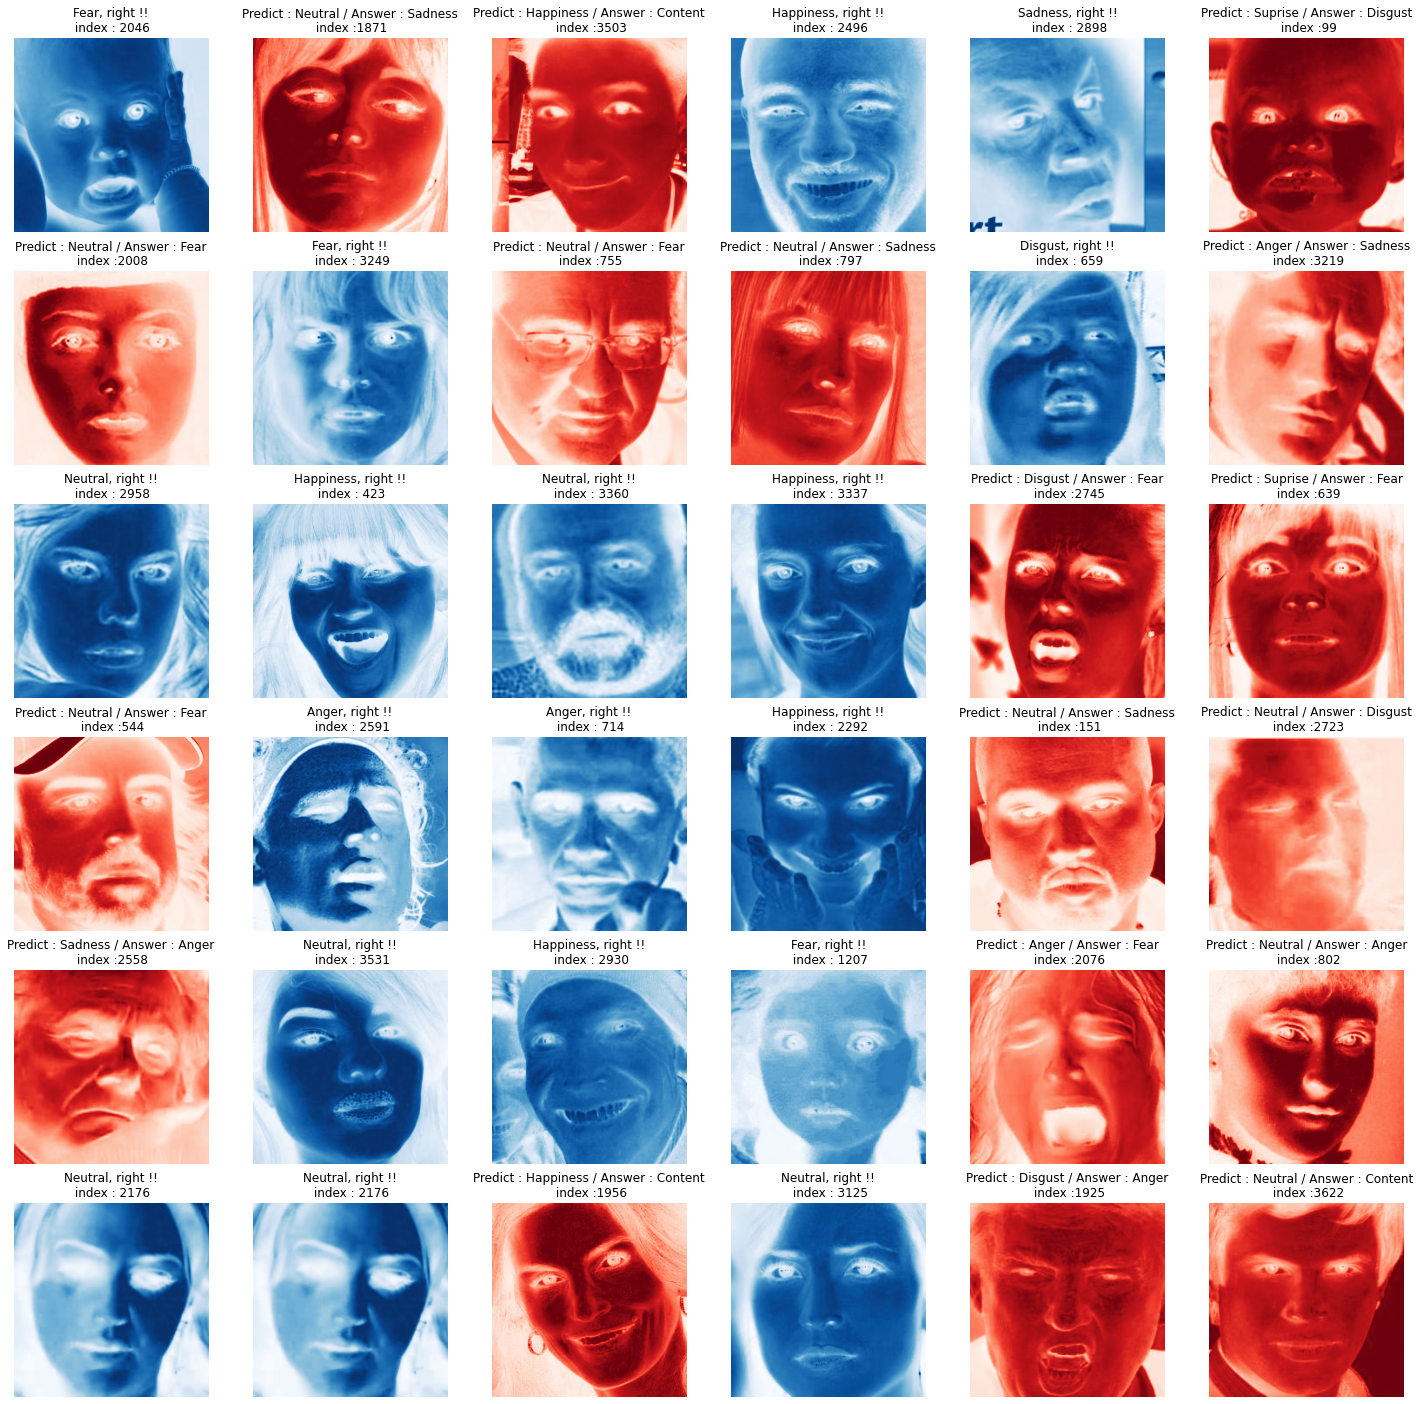

In [17]:
import cv2

columns = 6
rows = 6
fig = plt.figure(figsize=(25,25))

# inference
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device) 
    

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    #test_dataset = test_dataset.numpy()
    label = label_tags[test_dataset[data_idx][1].item()]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right !!\n index : ' + str(data_idx))
        cmap = 'Blues'
    else:
        plt.title('Predict : ' + pred + ' / Answer : ' +  label + '\n index :' + str(data_idx))
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    #plt.imshow(plot_img)
    plt.axis('off')
    
plt.show() 

In [20]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# 테스트 데이터에 대한 모델 테스트
https://learn.microsoft.com/ko-kr/windows/ai/windows-ml/tutorials/pytorch-train-model #보류